In [3]:
!pip install jsonlines

In [4]:
import jsonlines
import pandas as pd
from collections import defaultdict
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import matplotlib.pyplot as plt

data_file = '/content/split_file_0.jsonl'

shingle_counts = defaultdict(int)
shingle_phishing_counts = defaultdict(int)

with jsonlines.open(data_file) as reader:
    for obj in reader:
        num = obj['num']
        target = obj['target']
        for shingle in obj['shingles']:
            shingle_counts[shingle] += num
            if target == 1:
                shingle_phishing_counts[shingle] += num

shingle_data = []
for shingle, count in shingle_counts.items():
    phishing_count = shingle_phishing_counts[shingle]
    phishing_ratio = phishing_count / count if count > 0 else 0
    group = int(phishing_ratio * 5)
    shingle_data.append((shingle, phishing_ratio, group))

shingle_df = pd.DataFrame(shingle_data, columns=["shingle", "phishing_ratio", "group"])

X = shingle_df[['phishing_ratio', 'group']]
y = shingle_df['shingle'].apply(lambda x: 1 if x in shingle_phishing_counts and shingle_phishing_counts[x] > 0 else 0)
X['group'] = X['group'].astype('category')

<ipython-input-4-9567e6bfc343>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['group'] = X['group'].astype('category')


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.fc = nn.Linear(input_dim, hidden_dim)

    def forward(self, x):
        return self.fc(x)


In [7]:
class AutoencoderClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=2):
        super(AutoencoderClassifier, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)
        self.classifier = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        encoded = self.encoder(x)
        reconstructed = self.decoder(encoded)
        logits = self.classifier(encoded)
        return logits, reconstructed

Epoch 1/50:
  Accuracy: 0.9999
  Precision: 1.0000
  Recall: 0.9989
  F1 Score: 0.9994
Epoch 2/50:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 0.9999
  F1 Score: 0.9999
Epoch 3/50:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 0.9999
  F1 Score: 1.0000
Epoch 4/50:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 0.9999
  F1 Score: 1.0000
Epoch 5/50:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
Epoch 6/50:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
Epoch 7/50:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
Epoch 8/50:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
Epoch 9/50:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
Epoch 10/50:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
Epoch 11/50:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
Epoch 12/50:
  Accuracy: 1.0000
  Precisi

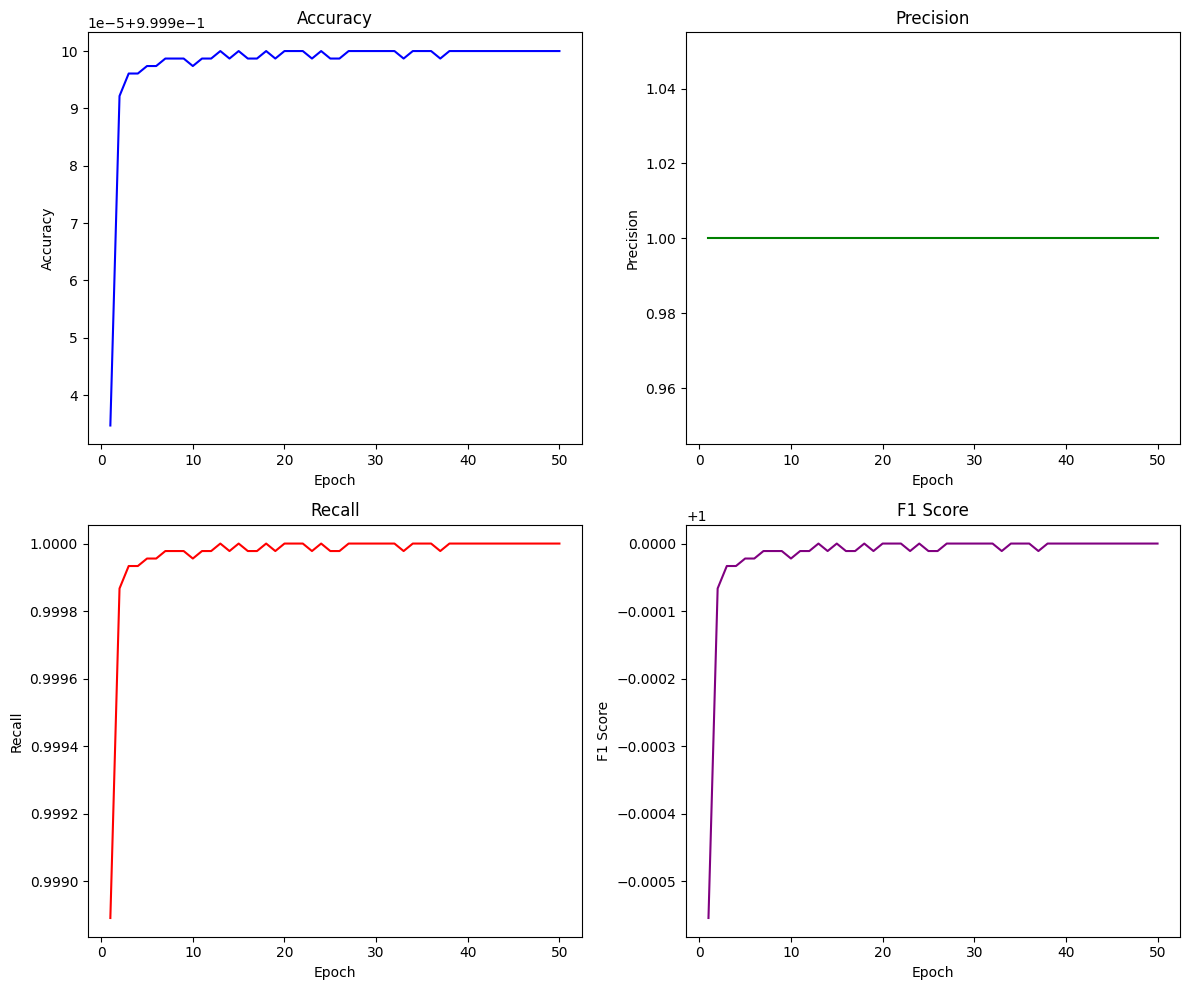

In [8]:
def train_autoencoder_classifier(model, train_loader, test_loader, epochs=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion_classification = nn.CrossEntropyLoss()
    criterion_reconstruction = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    accuracies, precisions, recalls, f1_scores = [], [], [], []

    for epoch in range(epochs):
        model.train()

        running_loss_classification = 0.0
        running_loss_reconstruction = 0.0

        for data in train_loader:
            X_batch, y_batch = data
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            logits, _ = model(X_batch)
            loss_classification = criterion_classification(logits, y_batch)
            loss = loss_classification
            loss.backward()
            optimizer.step()
            running_loss_classification += loss_classification.item()

        model.eval()
        y_pred_bin = []
        with torch.no_grad():
            for data in test_loader:
                X_batch, y_batch = data
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                logits, _ = model(X_batch)
                y_pred_bin.extend(torch.argmax(logits, dim=1).cpu().numpy())

        accuracy = accuracy_score(y_test, y_pred_bin)
        precision = precision_score(y_test, y_pred_bin)
        recall = recall_score(y_test, y_pred_bin)
        f1 = f1_score(y_test, y_pred_bin)

        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'  Accuracy: {accuracy:.4f}')
        print(f'  Precision: {precision:.4f}')
        print(f'  Recall: {recall:.4f}')
        print(f'  F1 Score: {f1:.4f}')

    return accuracies, precisions, recalls, f1_scores

model = AutoencoderClassifier(input_dim=X_train.shape[1], hidden_dim=128)
accuracies, precisions, recalls, f1_scores = train_autoencoder_classifier(model, train_loader, test_loader, epochs=50)

def plot_metrics(accuracies, precisions, recalls, f1_scores):
    plt.figure(figsize=(12, 10))

    plt.subplot(2, 2, 1)
    plt.plot(range(1, len(accuracies)+1), accuracies, label="Accuracy", color='blue')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.subplot(2, 2, 2)
    plt.plot(range(1, len(precisions)+1), precisions, label="Precision", color='green')
    plt.title('Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')

    plt.subplot(2, 2, 3)
    plt.plot(range(1, len(recalls)+1), recalls, label="Recall", color='red')
    plt.title('Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')

    plt.subplot(2, 2, 4)
    plt.plot(range(1, len(f1_scores)+1), f1_scores, label="F1 Score", color='purple')
    plt.title('F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')

    plt.tight_layout()
    plt.show()

plot_metrics(accuracies, precisions, recalls, f1_scores)
